# Pasos a seguir en el preprocesado de datos

Corregir, completar, Creación y Conversión.
Limpieza de datos, selección de características, extracción de características, transformación y creación.

## Obligatorios

1. Tratar valores faltantes o erróneos

    a. borrar fila (si tenemos suficientes registros)

    b. borrar la columna (si faltan demasiados valores en esa columna)

    c. imputar (SimpleImputer: media, mediana o moda)


2. Tratar los Outliers.

    a. IsolationForest - bastante buenos, no asumen ninguna distribución en concreto de los datos.

    b. IQR (Interquartile Range) - si sobrepasa el 1.5 por encima del tercero o por debajo del primero, va fuera.


3. Manipulación de datos (escalarlos):

    a. Estandarizar (todos los datos de una columna en la misma escala)

    b. Normalizer (todos los datos de una fila en la misma escala)

    c. Transformar las distribuciones (????????????????????????????????????)

4. Reducción de la dimensionalidad (siempre después de escalar los datos)

    a. SelectKBest (te quedas con las más importantes)
    
    b. Eliminación de las poco relevantes (RFE).

    c. Métodos del Árbol de Decisión.


## Opcionales 


5. Transformación de categóricos a numéricos (equivalente al pd.get_dummies):
    a. LabelEncoder (para la salida)
    b. OrdinalEncoder (para la entrada)
    c. OneHotEncoder

6. Creación de nuevas features significativas (PCA) -después de escalar y convertir los categóricos.


7. Discretización de los datos (binning)
    a. Binarizer
    b. KBinsDiscretizer


8. Corregir desbalanceo de datos y sesgos.



## 1. Tratar valores faltantes o erróneos 

Utilizaremos un método específico para primero detectar los NaN, y, una vez los tengamos identificados, ver cuál es la mejor solución.
Lo podemos hacer con algunos de estos:

a. SimpleImputer (mean, median, most_frequent, constant)

b. InterativeImputer (utiliza una regresión para rellenar, por defecto una bayesiana). Tiene la peculairidad de que aplica el fit y el transform por separado.

c. KNNImputer (utiliza el KNN para rellenar)

d. A tomar por culo. Nos cargamos la columna o las filas y santas pascuas.

In [ ]:
df = pd.read_csv('../data/student-por.csv', sep=';')
df.isnull().sum() #te va a sacar los nulos de cada columna

df = df.drop('famrel', axis=1) #A tomar por culo la columna, como famrel tenía más de 400 nulos, se va a la puta.

df.age = df.age.apply(lambda value: np.nan if value == '?' else value)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df_simple_age = pd.DataFrame(df_simple['age']) # 2 dimensiones

imputer.fit(df_simple_age)
df_simple['age'] = imputer.transform(df_simple_age)
df_simple['age'] = df_simple['age'].astype(int)
df_simple.head(15)


# Verificar que ahora la columna age tiene 0 nulos:
df_simple.isnull().sum()

## 2. Tratar Outliers

Observaremos las características de los Outliers y decidiremos si perjudican al modelo. De ser así, debemos ocuparnos de ellos. 
En este caso, una forma muy eficaz de tratar los outliers es con IsolationForest, ya que no asume ningún tipo de distribución. Aunque como alternativa también está el IQR.


In [ ]:
# ISOLATION FOREST

from sklearn.ensemble import IsolationForest
from sklearn import datasets
import pandas as pd

housing = datasets.fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target


X = housing.data
y = housing.target

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# A nivel interno, el entrenamiento asigna  una etiqueta de 1 a los datos normales y una etiqueta de -1 a los outliers
# iso = IsolationForest(contamination=0.01) # 0 a 0.5
iso = IsolationForest()
y_outliers = iso.fit_predict(X)
y_outliers

#Obtenem os el filtro, recordamos que están etiquetados los datos.
filter = y_outliers != -1

X_wo, y_wo = X[filter, :], y[filter]
print("X shape: ", X.shape)
print("X_wo shape: ", X_wo.shape)
print("Outliers borrados: ", X.shape[0] - X_wo.shape[0])

#Finalmente sacaríamos las métricas (esto sería una función con las métricas, veriamos que al quitar Outliers la cosa mejora)
calc_predictions(X_wo, y_wo)

In [ ]:
## IQR, reexaminar todo el códio del IQR que está en 2.PREPROCESADOS_TÉCNICAS

from collections import Counter
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """EG
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

housing = datasets.fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

outliers = detect_outliers(df, 2, df.drop('MedHouseVal', axis=1).columns) #Detectamos los Outliers
df.loc[outliers] # Los mostramos por pantalla
df = df.drop(outliers, axis=0).reset_index(drop=True) # Los quitamos del axis 0, es decir, todos los registros de outliers

X = df.drop(['MedHouseVal'], axis=1)
y = df['MedHouseVal']
calc_predictions(X, y)

## 3. Escalado de datos

### 3.1 Normalizer
Normalizer trata cada registro de forma INDIVIDUAL y pasa todos sus datos a la misma escala.
Esto es especialmente útil para ver qué peso tiene cada característica en cada registro de manera proporcional.
Imagínate este ejemplo:

Supongamos que tenemos una serie de documentos, y queremos intentar averiguar qué temática tienen. En este caso, no podemos atenernos al número de veces qué aparece cada palabra, sino en qué proporción aparece cada palabra documento. 

Si utilizásemos un MinMaxScaler normal, el resultado sería que aquellos documentos más largos parecería que tratan ciertos temas en mayor proporción que ciertos documentos de poca extensión. Aunque es probable que un documento de menor extensión aborde dicho tema en mayor profundidad. Para abordar esta situación, utilizaríamos un Normalizer.

### 3.2 MinMaxScaler

El valor más bajo valdría 0, el valor más alto valdría 1. Todos los demás quedarían entre medias. El problema del MinMaxScaler es que suprime el efecto de los Outliers, y eso puede ser un problema. Si este es el caso, otra opción sería utilizar StandarSCaller. Aquí, la desviación estándar puede variar, no es como en el StandarScaler que siempre dará 1 de desviación estándar.

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = np.array([[1, 200], [2, 300], [3, 400], [4, 500], [5, 600]])

scaler = MinMaxScaler()
minmax_data = scaler.fit_transform(data)

minmax_data

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [0.75, 0.75],
       [1.  , 1.  ]])

### 3.3 StandarScaller
El StandardScaler estandariza las características eliminando la media y escalando a una desviación estándar de 1. Esto significa que cada característica en los datos transformados tendrá una media de 0 y una desviación estándar de 1. Eso quiere decir que habrá valores que quedarán por encima de 1 o por debajo de -1, ya que los datos no están restringidos.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data = np.array([[1, 200], [2, 300], [3, 400], [4, 500], [5, 600]])

scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

standardized_data

array([[-1.41421356, -1.41421356],
       [-0.70710678, -0.70710678],
       [ 0.        ,  0.        ],
       [ 0.70710678,  0.70710678],
       [ 1.41421356,  1.41421356]])

## 4.1 Eliminación de features poco relevantes (SelectKBest)

Existen varios métodos para quedarnos con las features más relevantes. Los que podemos comentar son los siguientes:

1. SelectKBest: Este método selecciona las 𝑘 mejores características basándose en alguna función de puntuación estadística. Puedes elegir diferentes criterios de puntuación, como (chi-cuadrado) para datos categóricos, ANOVA F-value para datos continuos, entre otros.

2. Métodos basados en árboles de decisión: Los árboles de decisión, como los árboles de decisión individuales, los bosques aleatorios (Random Forests) y los modelos de boosting como XGBoost, tienen un atributo llamado feature_importances_ que proporciona una puntuación de importancia para cada característica. Estas puntuaciones pueden usarse para seleccionar las características más relevantes.

3. RFE (Recursive Feature Elimination): Este es un método iterativo que ajusta un modelo y elimina las características más débiles hasta alcanzar el número deseado de características. RFE utiliza un estimador (como una regresión lineal o un árbol de decisión) para evaluar la importancia de cada característica en cada iteración.

El método por defecto de SelectKBest en ScikitLearn es el valor F de ANOVA (ANOVA F-value). Este método se usa para seleccionar las mejores características basándose en el valor F de ANOVA entre cada característica y la variable objetivo. El valor F de ANOVA mide la relación de varianza entre los grupos a la varianza dentro de los grupos, lo que es útil para datos continuos.

In [10]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest

# Cargar el conjunto de datos
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names

# Seleccionar las 2 mejores características utilizando ANOVA F-value (por defecto)
selector = SelectKBest(k=2)
X_new = selector.fit_transform(X, y)

# Obtener los nombres de las características seleccionadas
selected_features = selector.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_features]

# Convertir las características seleccionadas en un DataFrame
df_selected = pd.DataFrame(X_new, columns=selected_feature_names)
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Realizar un describe() en el DataFrame
df_selected.describe()
iris_df.describe()



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## 5.1 Codificación de variables categóricas (LabelEncoder)

Esto es el equivalente al pd.get_dummies(), pero aquí vamos a hacerlo con métodos propios de sklearn.
Concretamente, el que vamos a ver es el LabelEncoder (salida) y OrdinalEconder (entrada):

In [ ]:
#LABEL ENCONDER: PARA LA SALIDA

df = pd.read_csv("../data/sonar.csv")

X = df.drop('label', axis=1) #separamos la X
y = df['label'] #separamos la y, que es la que vamos a aplicar el labelEncoder

from sklearn.preprocessing import LabelEncoder

# pasar y de categórico a numérico.
# OrdinalEncoder se utiliza en las entradas (X)
# LabelEncoder se utiliza en la salida (y)
encoder = LabelEncoder()
y = encoder.fit_transform(y)


## 5.2 Codificación de variables categóricas (OrdinalEncoder / LabelEncoder)

Para codificación de los categóricos, tenemos 3 modelos:

1. OrdinalEncoder. Se utiliza con los valores de entrada, la X. Por lo general, el proceso es aplicar el OrdinalEconder y después concatenar estos datos con los originales.

2. LabelEncoder. Se utiliza únicamente con los valores de salida, la y.

3. OneHotEncoder. Es igual que el get_dummies() de pandas. Coge el categórico y crea tantas columnas como categorías haya. Si se cumple la condicón pone 1, si no se cumple, pone 0.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Supongamos que tenemos el siguiente DataFrame
df = pd.DataFrame({
    'edad': [23, 45, 31],
    'tamaño_categorico': ['pequeño', 'mediano', 'grande'],
    'ingreso': [50000, 60000, 55000],
    'label': ['A', 'B', 'A']
})

# Identificar las columnas categóricas y numéricas
columnas_categoricas = ['tamaño_categorico']
columnas_numericas = ['edad', 'ingreso']

# Separar las columnas categóricas y numéricas
X_categorico = df[columnas_categoricas]
X_numerico = df[columnas_numericas]

# Transformar las columnas categóricas
ordinal_encoder = OrdinalEncoder()
X_categorico_encoded = ordinal_encoder.fit_transform(X_categorico)

# CREAR UN NUEVO DATAFRAME CON LA TRANSFORMACIÓN DE LAS CATEGÓRICAS!!!
X_categorico_encoded_df = pd.DataFrame(X_categorico_encoded, columns=columnas_categoricas)

# CONCATENAMOS NUESTRAS NUMÉRICAS ORIGINALES CON LAS QUE HEMOS TRANSFORMADO HACE UN SEGUNDO
X_final = pd.concat([X_numerico, X_categorico_encoded_df], axis=1)

# Transformar la variable de salida con LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])

print(X_final)
print(y_encoded)


# 6 Análisis de los Compomentes Principales (PCA) - Después de escalar y codificar los categóricos


Es imperativo mencionar que un conjunto de características debe normalizarse antes de aplicar PCA. Por ejemplo, si un conjunto de características tiene datos expresados en unidades de kilogramos, años luz o millones, la escala de variación es enorme en el conjunto de entrenamiento. Si se aplica PCA en un conjunto de características de este tipo, las cargas resultantes para las características con una varianza alta también serán grandes. Por lo tanto, los componentes principales estarán sesgados hacia características con una gran variación, lo que generará resultados falsos. Para ello escalamos los datos con: MinMaxScaler o StandardScaler.

Finalmente, el último punto a recordar antes de comenzar a codificar es que PCA es una técnica estadística y solo se puede aplicar a datos numéricos. Por lo tanto, las características categóricas deben convertirse en características numéricas antes de poder aplicar PCA.


La PCA busca ordenar las características desde las que provocan mayor varianza hasta las que menos. 

Una alta varianza se considera más importante en el contexto de PCA porque indica la dirección en la que los datos están más dispersos, y capturar esta varianza permite retener la mayor cantidad de información posible al reducir las dimensiones del conjunto de datos. Este enfoque asegura que las características más importantes y la estructura subyacente de los datos se mantengan al simplificar el modelo.


# 7. Distribución de datos

Para evitar sesgos, puede plantearse preprocesar la distribución de datos. Dentro de este apartado existen varias técnicas, como CunatileTransformer, PowerTransformer o BoxCox. Nosotros nos vamos a centrar en CuantileTransformer.

QuantileTransformer transforma las características de modo que sigan una distribución específica al utilizar cuantiles. Esto implica que se mapean los datos originales a nuevos valores utilizando sus posiciones en la distribución acumulada (CDF). Esto tiene el efecto de eliminar la influencia de la forma original de la distribución de los datos, resultando en datos que siguen la distribución deseada.

### Principales Parámetros y Opciones
1. output_distribution: Este parámetro define la distribución de salida. Las opciones son:

'uniform': Transforma los datos para que sigan una distribución uniforme.
'normal': Transforma los datos para que sigan una distribución gaussiana (normal).
n_quantiles: Número de cuantiles a utilizar para dividir los datos. Más cuantiles pueden llevar a una transformación más precisa, pero a costa de mayor tiempo de computación.

2. subsample: Si el número de muestras en los datos es mayor que este valor, se utilizará una muestra aleatoria de las primeras subsample muestras para ajustar la transformación.

3. random_state: Semilla para la generación de números aleatorios, útil para reproducibilidad.

<Axes: xlabel='feature1', ylabel='Count'>

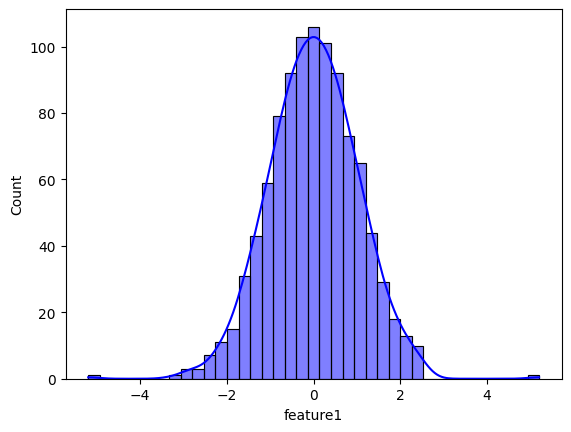

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

# Crear un DataFrame de ejemplo
data = {
    'feature1': np.random.exponential(scale=2, size=1000),  # Distribución exponencial
    'feature2': np.random.normal(loc=0, scale=1, size=1000) # Distribución normal
}
df = pd.DataFrame(data)

# Inicializar el QuantileTransformer
transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0)

# Ajustar y transformar los datos
df_transformed = transformer.fit_transform(df)

# Convertir de nuevo a DataFrame para facilitar la visualización
df_transformed = pd.DataFrame(df_transformed, columns=df.columns)

# Mostrar las primeras filas del DataFrame transformado
df_transformed.describe()

#Y aquí vemos cómo lo que iba a ser una distribución exponencial, se convierte en guasina
sns.histplot(df_transformed['feature1'], kde=True, color='blue', label='Original')


# 8. Descritización

Conviertes variables continuas en variables discretas (rangos). Las dos que se utilizan con ScikitLearn son KbinsDiscretizer y Binarizer. El binarizer no lo vamos a explicar ya que únicamente transformar en 0 o en 1. Es decir, o sí o no entra en la categoría. Esto mismo se puede conseguir con un KbinsDiscretizer de n_bins=2. Pero puede ser útil repasar el Binarizer en el futuro.

## KbinsDiscretizer

La discretización con KBinsDiscretizer puede ser útil en situaciones donde se necesita convertir características numéricas en categorías para su uso en modelos que requieren variables categóricas. Al crear una instancia de KBinsDiscretizer, se especifican varios parámetros importantes:

### n_bins: 
Especifica el número de bins (contenedores) en los que se discretizará la variable. Puedes especificar un único valor entero para bins de igual anchura o una lista para bins de igual frecuencia.

### strategy: 
Determina la estrategia de discretización. Puede ser:

-'uniform': Todos los bins tienen la misma anchura.

-'quantile': Todos los bins tienen la misma cantidad de puntos de datos.

-'kmeans': Los bins se forman utilizando el algoritmo de K-means.


### encode: 

Especifica cómo codificar las variables discretizadas. Puede ser 'ordinal' para codificar como números enteros o 'onehot' para codificar como variables dummy.


In [10]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# Datos de ejemplo
X = np.array([[0, 2], [1, 3], [2, 4], [3, 5]])

# Crear el discretizador
enc = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')

# Ajustar y transformar los datos
X_binned = enc.fit_transform(X)

X_binned

array([[0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.]])

# 9. Creación de nuesvas features o eliminación manual

Este paso normalmente es más manual, ya que responde a un análisis de los datos que tengamos. Por ejemplo, en el titanic, podemos crear una variable de 'viaja solo' si el tamaño de la familia es == 1.

O si hubiese demasiadas categorías, podríamos simplificar las categorías por "otros" para aquellas que no tienen demasiados registros. Esto puede simplificar los datos.